# Validating Strawberry Puree via Infrared Spectral Analysis

<br>
<br>

The purpose of this analysis is to classify strawberry puree as "pure" or "not-pure" by analyzing the frequency domain in the mid-infrared spectrum using Attenuated Total Reflectance sampling.  Not-pure samples have been adulterated with other fruit purees.  

Spectral analysis is a common practice in analyzing fruit and vegetables.  Here, we use a back prop network with 5 hidden layers.

<br>
<br>

~~The Input Layer is made up of 235 nodes.  Each input node represents the strength of a specific wavenumber

~~Hidden Layers 1 and 5 have 1000 ReLU nodes

~~Hidden Layers 2,3 and 4 have 10000

~~The Output Layer is made up of 2 nodes representing unadulerated strawberry puree or the adulterated version.

<br>
<br>
<br>

The data used in this notebook came from an original analysis by Holland, Kemsley and Wilson.

<i>"Use of Fourier transform infrared spectroscopy and partial least squares regression for the detection of adulteration of strawberry purees" Holland JK, Kemsley EK, Wilson RH. (1998). Journal of the Science of Food and Agriculture, 76, 263-269</i>

Abstract and Full-text (paywall) are available here: https://europepmc.org/article/agr/ind21806286

The dataset was downloaded from: http://www.timeseriesclassification.com/description.php?Dataset=Strawberry

<br>
<br>
<br>


## Side note:

I deliberately threw the bus at the problem.  There is no need  for so many dense layers.  There is no need to 80 epochs of training.  This was just a feasibility study and needs to be cleaned up.

<br>
<br>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
%matplotlib inline

# set sensible default parameters for matplotlib
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

plt.style.use('dark_background')


In [2]:
import torch
print('CUDA available: '.ljust(25), torch.cuda.is_available())
print('CUDA device count: '.ljust(25), torch.cuda.device_count())

current_device = torch.cuda.current_device()
print('Current CUDA Device num: '.ljust(25), current_device)
# torch.cuda.device(current_device)
print('Current CUDA Device: '.ljust(25), torch.cuda.get_device_name(current_device))


CUDA available:           True
CUDA device count:        1
Current CUDA Device num:  0
Current CUDA Device:      GeForce RTX 2070 SUPER


In [3]:
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
df = pd.read_csv('MIR_Fruit_purees.csv')
df.head()

,Wavenumbers,NON-Strawberry,NON-Strawberry.1,NON-Strawberry.2,NON-Strawberry.3,NON-Strawberry.4,NON-Strawberry.5,NON-Strawberry.6,NON-Strawberry.7,NON-Strawberry.8,...,NON-Strawberry.622,NON-Strawberry.623,NON-Strawberry.624,NON-Strawberry.625,NON-Strawberry.626,NON-Strawberry.627,NON-Strawberry.628,NON-Strawberry.629,NON-Strawberry.630,NON-Strawberry.631
0,899.327,0.002806,0.002637,0.002416,0.002345,0.002303,0.002514,0.002105,0.002018,0.002154,...,0.002539,0.002569,0.002723,0.002542,0.002627,0.002631,0.002730,0.002713,0.002697,0.002789
1,903.187,0.002732,0.002638,0.002480,0.002292,0.002342,0.002488,0.002078,0.001999,0.002165,...,0.002507,0.002569,0.002714,0.002539,0.002629,0.002651,0.002839,0.002779,0.002905,0.003040
2,907.047,0.002661,0.002651,0.002511,0.002249,0.002350,0.002477,0.002077,0.001945,0.002191,...,0.002483,0.002541,0.002740,0.002574,0.002619,0.002696,0.002999,0.002877,0.003277,0.003359
3,910.907,0.002657,0.002757,0.002611,0.002303,0.002419,0.002542,0.002154,0.001964,0.002275,...,0.002563,0.002599,0.002861,0.002664,0.002714,0.002809,0.003259,0.003085,0.003711,0.003796
4,914.767,0.002699,0.003000,0.002802,0.002466,0.002561,0.002713,0.002311,0.002083,0.002470,...,0.002764,0.002806,0.003090,0.002829,0.002939,0.003022,0.003649,0.003419,0.004265,0.004394


<br>
<br>

# Data Wrangling

### Isolate Wavenumbers from the dataframe

In [5]:
# isolate the wavenumbers into a new variable
wavenumbers = df.iloc[:,0]

In [6]:
# remove "Wavenumbers" from the original df prior to Transposing
df.drop(labels='Wavenumbers', axis=1, inplace=True)

<br>

### Transpose the dataframe, and rename the output variable

In [7]:
# Transpose the df and reset index, then rename the old index
df = df.T
df = df.reset_index()
df = df.rename(columns={'index': 'Outcome'})

# shuffle the df so Outcome is at the end 
df = df.iloc[:,1:].join(df.iloc[:,0])

<br>

### Rename the Columns as Wavenumbers

In [8]:
# convert the wavenumbers to columns and round them down to 3 decimal places
cols = [ round(f, 3) for f in wavenumbers.to_list() ]

# add the final column name 'Outcome' to the list and set the df columns 
cols.append('Outcome')
df.columns = cols

# sort the df by Outcome and reset index
df = df.sort_values('Outcome').reset_index(drop=True)

df

,899.327,903.187,907.047,910.907,914.767,918.627,922.487,926.347,930.207,934.067,...,1771.684,1775.544,1779.404,1783.264,1787.124,1790.984,1794.844,1798.704,1802.564,Outcome
0,0.002806,0.002732,0.002661,0.002657,0.002699,0.002762,0.002749,0.002686,0.002637,0.002617,...,0.000348,0.000216,0.000166,0.000117,0.000087,0.000046,0.000011,0.000009,0.000009,NON-Strawberry
1,0.002637,0.002638,0.002651,0.002757,0.003000,0.003313,0.003412,0.003302,0.003162,0.003060,...,0.000013,0.000006,-0.000005,-0.000005,-0.000006,0.000002,0.000010,0.000005,0.000005,NON-Strawberry.1
2,0.002054,0.002039,0.002030,0.002076,0.002202,0.002350,0.002408,0.002352,0.002276,0.002273,...,0.000466,0.000294,0.000192,0.000125,0.000077,0.000054,0.000035,0.000014,0.000014,NON-Strawberry.10
3,0.002330,0.002332,0.002291,0.002328,0.002482,0.002639,0.002655,0.002555,0.002467,0.002428,...,0.000337,0.000219,0.000111,0.000071,0.000024,0.000052,0.000061,0.000018,0.000018,NON-Strawberry.100
4,0.002562,0.002565,0.002584,0.002691,0.002886,0.003113,0.003233,0.003239,0.003178,0.003077,...,0.000307,0.000199,0.000126,0.000082,0.000051,0.000041,0.000029,0.000009,0.000009,NON-Strawberry.101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,0.002123,0.002187,0.002206,0.002206,0.002351,0.002564,0.002668,0.002598,0.002560,0.002507,...,0.000254,0.000151,0.000096,0.000066,0.000043,0.000038,0.000037,0.000014,0.000014,Strawberry.95
979,0.002384,0.002392,0.002383,0.002491,0.002710,0.002888,0.002948,0.002914,0.002822,0.002701,...,0.000103,0.000054,0.000021,0.000012,0.000005,0.000015,0.000026,0.000013,0.000013,Strawberry.96
980,0.002449,0.002499,0.002506,0.002657,0.002912,0.003137,0.003310,0.003324,0.003217,0.003085,...,0.000103,0.000057,0.000035,0.000020,0.000016,0.000015,0.000009,0.000007,0.000007,Strawberry.97
981,0.002276,0.002358,0.002431,0.002593,0.002830,0.003089,0.003257,0.003285,0.003238,0.003143,...,0.000184,0.000102,0.000060,0.000032,0.000023,0.000019,0.000014,0.000013,0.000013,Strawberry.98


<br>
<br>

### Convert the Dependent Variable to True or False values

Binary classification problem

In [9]:
# replace NON Strawberry outcomes with False
df.loc[:, 'Outcome'] = df.loc[:,'Outcome'].replace(to_replace=r'^NON.*$', value=False, regex=True)

# replace Strawberry with True
df.loc[:, 'Outcome'] = df.loc[:,'Outcome'].replace(to_replace=r'^Straw.*$', value=True, regex=True)

In [10]:
df

,899.327,903.187,907.047,910.907,914.767,918.627,922.487,926.347,930.207,934.067,...,1771.684,1775.544,1779.404,1783.264,1787.124,1790.984,1794.844,1798.704,1802.564,Outcome
0,0.002806,0.002732,0.002661,0.002657,0.002699,0.002762,0.002749,0.002686,0.002637,0.002617,...,0.000348,0.000216,0.000166,0.000117,0.000087,0.000046,0.000011,0.000009,0.000009,False
1,0.002637,0.002638,0.002651,0.002757,0.003000,0.003313,0.003412,0.003302,0.003162,0.003060,...,0.000013,0.000006,-0.000005,-0.000005,-0.000006,0.000002,0.000010,0.000005,0.000005,False
2,0.002054,0.002039,0.002030,0.002076,0.002202,0.002350,0.002408,0.002352,0.002276,0.002273,...,0.000466,0.000294,0.000192,0.000125,0.000077,0.000054,0.000035,0.000014,0.000014,False
3,0.002330,0.002332,0.002291,0.002328,0.002482,0.002639,0.002655,0.002555,0.002467,0.002428,...,0.000337,0.000219,0.000111,0.000071,0.000024,0.000052,0.000061,0.000018,0.000018,False
4,0.002562,0.002565,0.002584,0.002691,0.002886,0.003113,0.003233,0.003239,0.003178,0.003077,...,0.000307,0.000199,0.000126,0.000082,0.000051,0.000041,0.000029,0.000009,0.000009,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,0.002123,0.002187,0.002206,0.002206,0.002351,0.002564,0.002668,0.002598,0.002560,0.002507,...,0.000254,0.000151,0.000096,0.000066,0.000043,0.000038,0.000037,0.000014,0.000014,True
979,0.002384,0.002392,0.002383,0.002491,0.002710,0.002888,0.002948,0.002914,0.002822,0.002701,...,0.000103,0.000054,0.000021,0.000012,0.000005,0.000015,0.000026,0.000013,0.000013,True
980,0.002449,0.002499,0.002506,0.002657,0.002912,0.003137,0.003310,0.003324,0.003217,0.003085,...,0.000103,0.000057,0.000035,0.000020,0.000016,0.000015,0.000009,0.000007,0.000007,True
981,0.002276,0.002358,0.002431,0.002593,0.002830,0.003089,0.003257,0.003285,0.003238,0.003143,...,0.000184,0.000102,0.000060,0.000032,0.000023,0.000019,0.000014,0.000013,0.000013,True


<br>
<br>
<br>

# EDA on the Spectra

### Plot wavenumbers for Strawberry == True

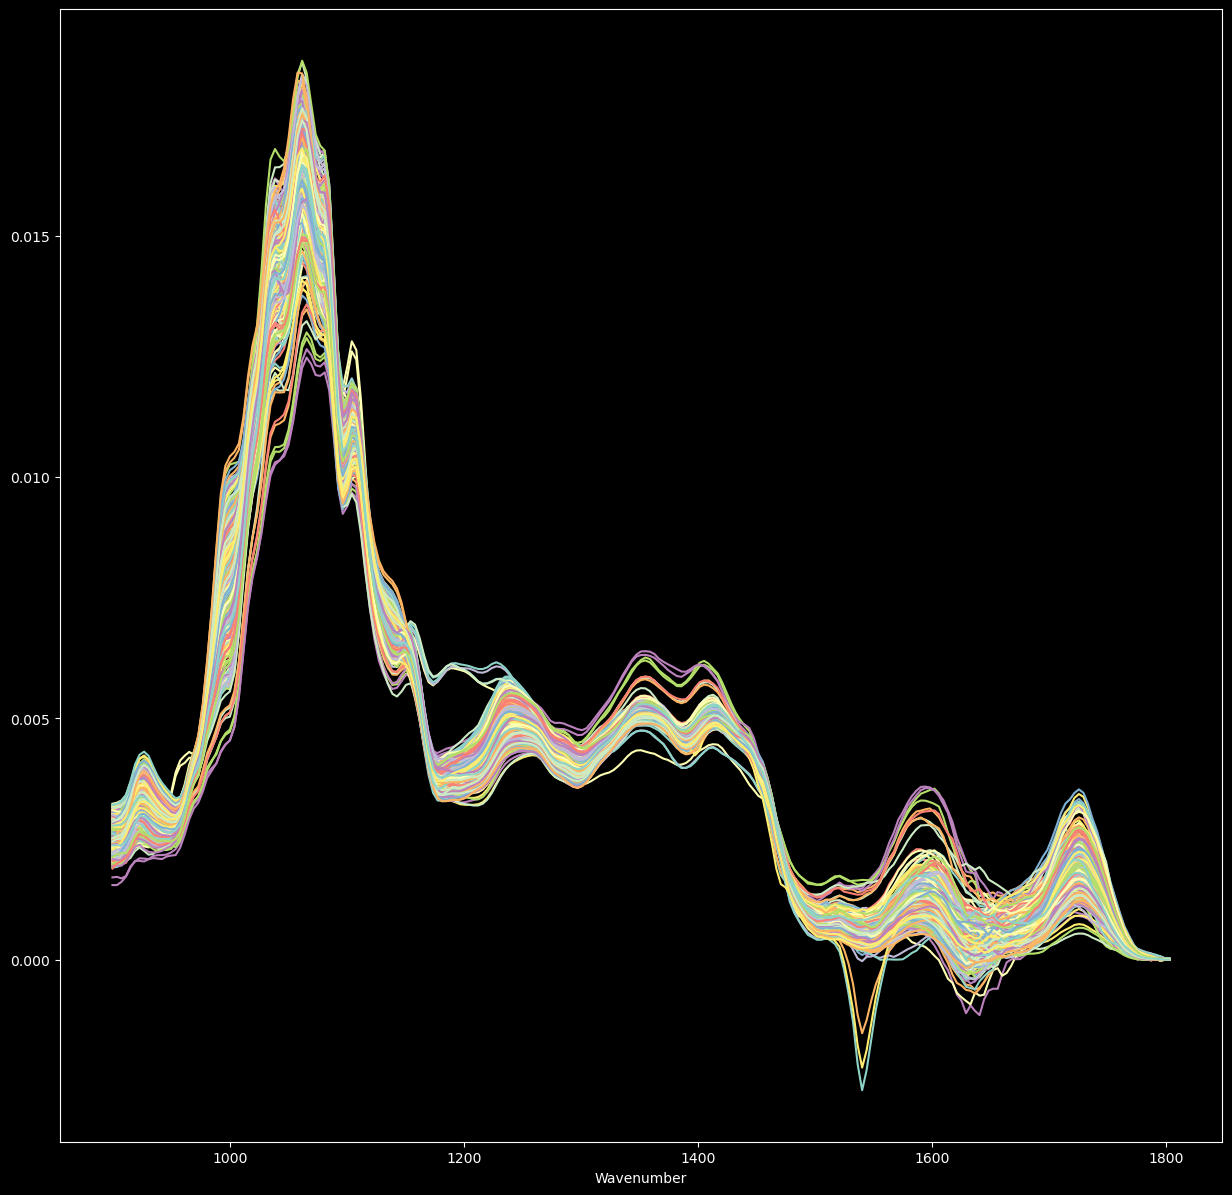

In [11]:
# plot wavenumber vs emission where Strawberry == True
plt.figure(figsize=(15,15))
plt.plot(df.query('Outcome == True').loc[:,df.columns != 'Outcome'].T)
plt.xlabel('Wavenumber');

<br>
<br>

### Plot wavenumbers for Strawberry == False

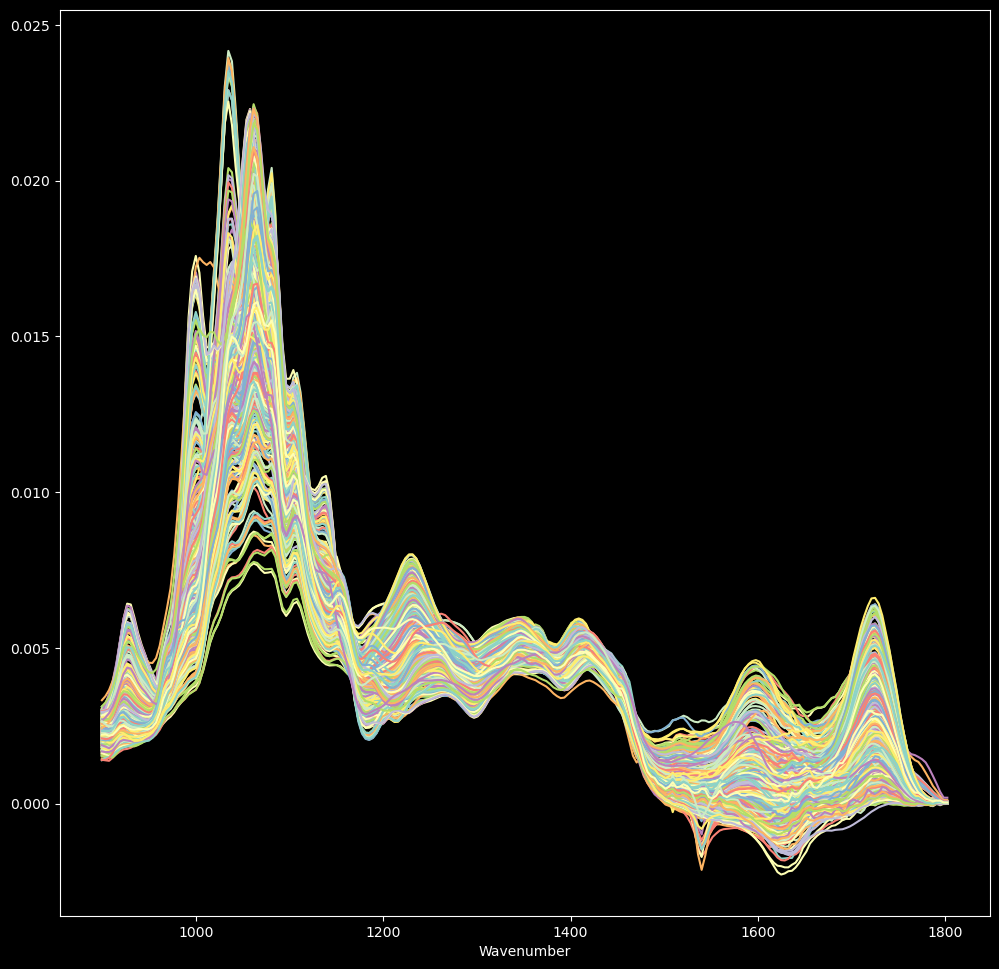

In [12]:
# plot the wavenumber vs emission where Strawberry == False
plt.figure(figsize=(12,12))
plt.plot(df.query('Outcome == False').loc[:,df.columns != 'Outcome'].T)
plt.xlabel('Wavenumber');

<br>
<br>

### Split the Data into Training and Validation Sets

In [13]:
# subset 30% of the dataframe to make up the validation set
dfv = df.sample(frac=0.3, replace=False, random_state=4)

# assign the rest as the training set
dft = df.drop(dfv.index)

In [14]:
# Shuffle
dft = dft.sample(len(dft))
dfv = dfv.sample(len(dfv))

In [15]:
dfv

,899.327,903.187,907.047,910.907,914.767,918.627,922.487,926.347,930.207,934.067,...,1771.684,1775.544,1779.404,1783.264,1787.124,1790.984,1794.844,1798.704,1802.564,Outcome
669,0.002749,0.002710,0.002706,0.002770,0.002931,0.003111,0.003160,0.003045,0.002907,0.002802,...,0.000049,0.000022,-2.657170e-07,-0.000002,7.998660e-07,0.000013,0.000020,1.315130e-05,1.315130e-05,True
477,0.002808,0.002806,0.002797,0.002890,0.003128,0.003399,0.003501,0.003421,0.003302,0.003201,...,0.000083,0.000052,1.331920e-05,0.000009,-3.362880e-06,0.000016,0.000026,6.281530e-06,6.281530e-06,False
737,0.002265,0.002224,0.002188,0.002260,0.002418,0.002561,0.002571,0.002477,0.002402,0.002374,...,0.000127,0.000071,4.183910e-05,0.000023,8.887160e-06,0.000012,0.000005,-3.488820e-07,-3.488820e-07,True
805,0.002612,0.002661,0.002732,0.002868,0.003125,0.003417,0.003657,0.003762,0.003711,0.003573,...,0.000257,0.000166,1.095370e-04,0.000072,4.660270e-05,0.000030,0.000020,1.132210e-05,1.132210e-05,True
113,0.002196,0.002183,0.002153,0.002184,0.002316,0.002449,0.002548,0.002573,0.002523,0.002483,...,0.000508,0.000351,2.107600e-04,0.000128,6.468540e-05,0.000037,0.000044,1.372260e-05,1.372260e-05,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,0.002323,0.002343,0.002349,0.002456,0.002633,0.002789,0.002844,0.002805,0.002725,0.002635,...,0.000166,0.000091,5.611430e-05,0.000034,2.387740e-05,0.000022,0.000016,1.105470e-05,1.105470e-05,True
406,0.001516,0.001506,0.001490,0.001480,0.001592,0.001740,0.001811,0.001835,0.001854,0.001888,...,0.000541,0.000339,2.426970e-04,0.000162,1.088710e-04,0.000069,0.000031,1.823660e-05,1.823660e-05,False
885,0.002137,0.002153,0.002226,0.002340,0.002513,0.002687,0.002780,0.002792,0.002743,0.002661,...,0.000220,0.000117,7.358680e-05,0.000050,3.112350e-05,0.000026,0.000016,7.994040e-06,7.994040e-06,True
490,0.001929,0.001921,0.001905,0.001983,0.002154,0.002293,0.002320,0.002261,0.002214,0.002218,...,0.000309,0.000185,1.220490e-04,0.000084,5.979530e-05,0.000042,0.000019,7.601900e-06,7.601900e-06,False


In [16]:
dft

,899.327,903.187,907.047,910.907,914.767,918.627,922.487,926.347,930.207,934.067,...,1771.684,1775.544,1779.404,1783.264,1787.124,1790.984,1794.844,1798.704,1802.564,Outcome
275,0.002729,0.002659,0.002613,0.002667,0.002815,0.002966,0.002941,0.002805,0.002679,0.002587,...,0.000034,0.000031,0.000027,0.000025,0.000022,0.000019,0.000011,0.000007,0.000007,False
291,0.001807,0.001777,0.001731,0.001824,0.001958,0.002040,0.002065,0.002026,0.002017,0.002056,...,0.000469,0.000293,0.000191,0.000124,0.000081,0.000053,0.000028,0.000015,0.000015,False
833,0.002839,0.002832,0.002890,0.003008,0.003219,0.003478,0.003661,0.003711,0.003618,0.003444,...,0.000248,0.000149,0.000117,0.000079,0.000063,0.000038,0.000004,0.000007,0.000007,True
533,0.002454,0.002570,0.002687,0.002928,0.003348,0.003835,0.004192,0.004355,0.004309,0.004122,...,0.000160,0.000085,0.000049,0.000025,0.000015,0.000011,0.000007,0.000002,0.000002,False
670,0.002858,0.002902,0.002962,0.003140,0.003406,0.003690,0.003892,0.003950,0.003858,0.003687,...,0.000101,0.000064,0.000060,0.000042,0.000041,0.000013,-0.000006,0.000004,0.000004,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,0.002388,0.002343,0.002308,0.002371,0.002535,0.002695,0.002716,0.002636,0.002554,0.002496,...,0.000266,0.000165,0.000109,0.000068,0.000043,0.000028,0.000016,0.000006,0.000000,False
484,0.002775,0.002720,0.002703,0.002777,0.002945,0.003158,0.003224,0.003121,0.003007,0.002937,...,0.000118,0.000073,0.000011,0.000007,-0.000008,0.000026,0.000042,0.000011,0.000011,False
843,0.003027,0.003019,0.003062,0.003113,0.003291,0.003526,0.003626,0.003627,0.003542,0.003394,...,0.000245,0.000166,0.000134,0.000095,0.000081,0.000029,0.000002,0.000010,0.000010,True
526,0.002020,0.001984,0.001959,0.002011,0.002155,0.002280,0.002324,0.002225,0.002141,0.002131,...,0.000366,0.000232,0.000151,0.000098,0.000060,0.000040,0.000024,0.000013,0.000013,False


<br>
<br>

## ~~Normalize the data~~

In [17]:
# Find the maximum value of all the independent variables in the Training Set
# maxval = dft.iloc[:, :-1].max().max()  # max of each column , then max of all columns
# maxval

In [18]:
# Normalize the training set against the maxval and add the output variable back in
# dft_norm = dft.iloc[:, :-1] / maxval
# dft_norm = dft_norm.join(dft.iloc[:, -1])

# dft_norm

In [19]:
# Normalize the validation set against the maxval and add the output variable back in
# We use the same maxval of the training set to avoid peeking into the future
# dfv_norm = dfv.iloc[:, :-1] / maxval
# dfv_norm = dfv_norm.join(dfv.iloc[:, -1])

# dfv_norm

<br>
<br>

### Plot the Split and Normalized Data

#### Plot the Training Set where Strawberry == True

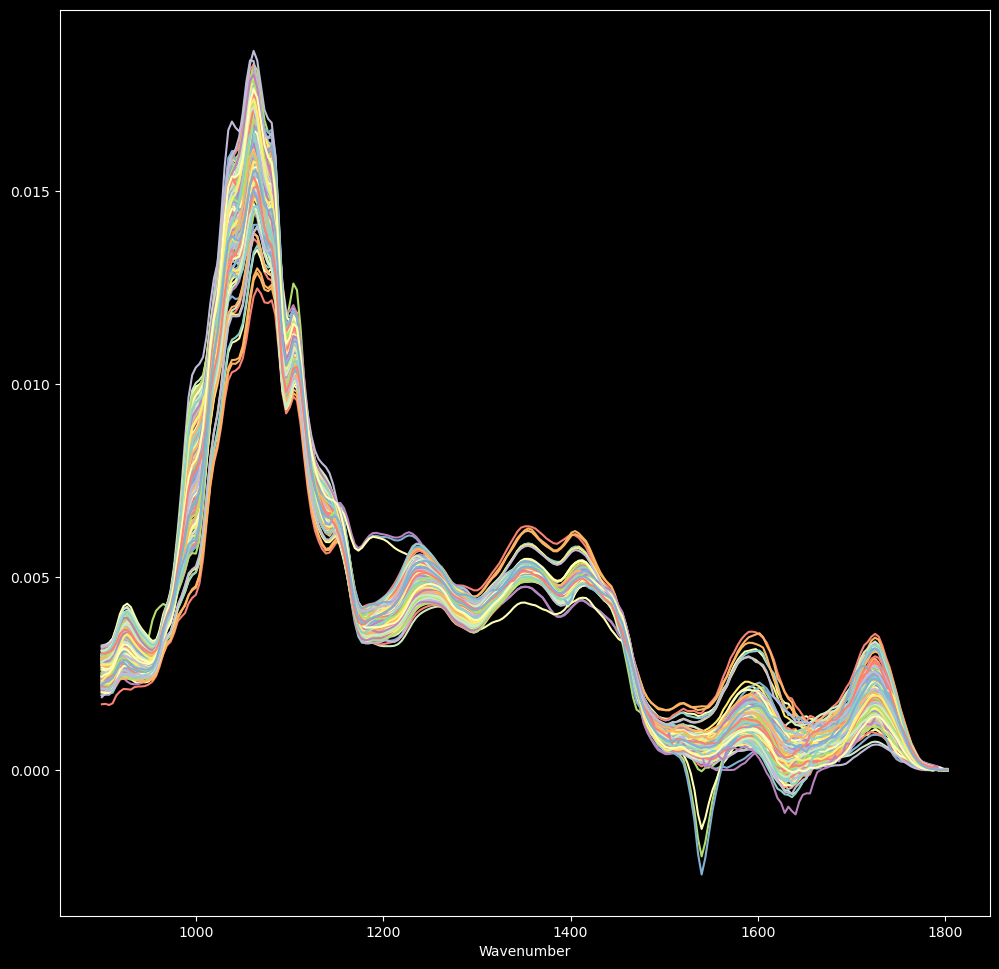

In [20]:
# plot wavenumber vs emission where Strawberry == True
plt.figure(figsize=(12,12))
plt.plot(dft.query('Outcome == True').loc[:,dft.columns != 'Outcome'].T)
plt.xlabel('Wavenumber');

<br>

#### Plot the Training Set where Strawberry == False

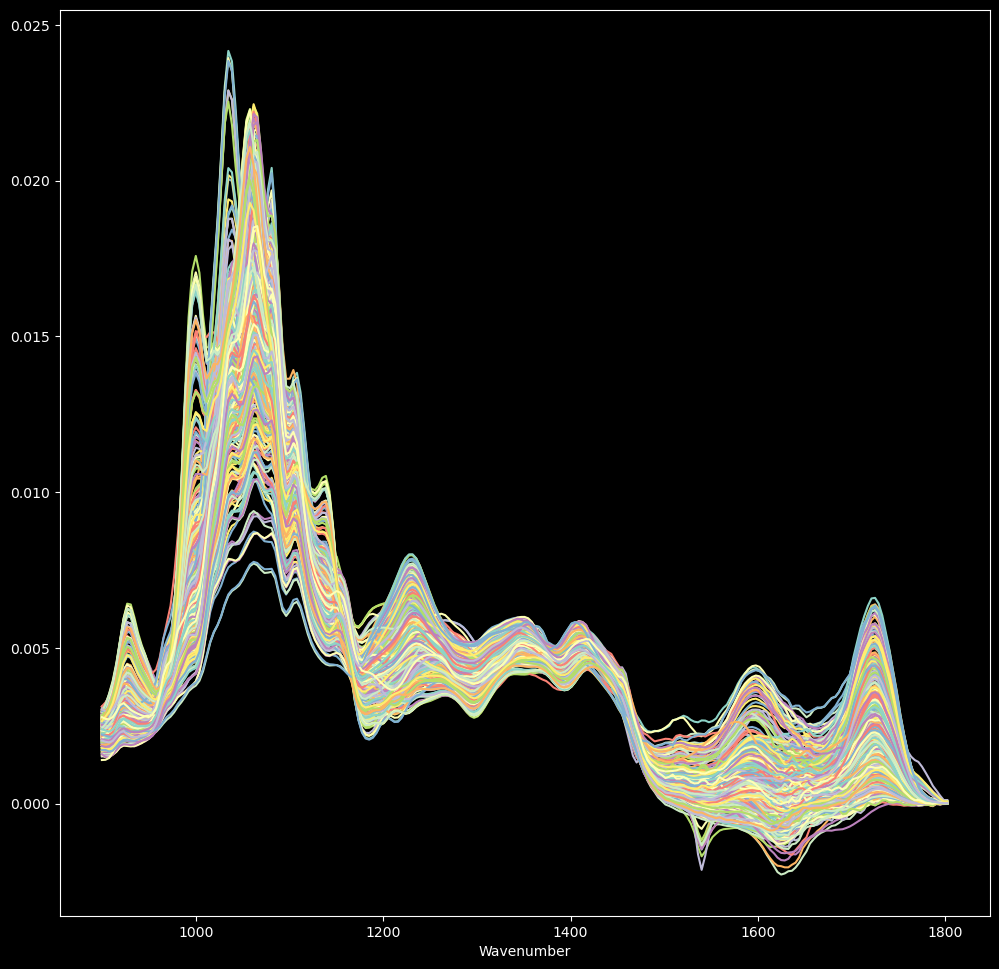

In [21]:
# plot the wavenumber vs emission where Strawberry == False
plt.figure(figsize=(12,12))
plt.plot(dft.query('Outcome == False').loc[:,dft.columns != 'Outcome'].T)
plt.xlabel('Wavenumber');

<br>

#### Plot the Validation Set where Strawberry == True

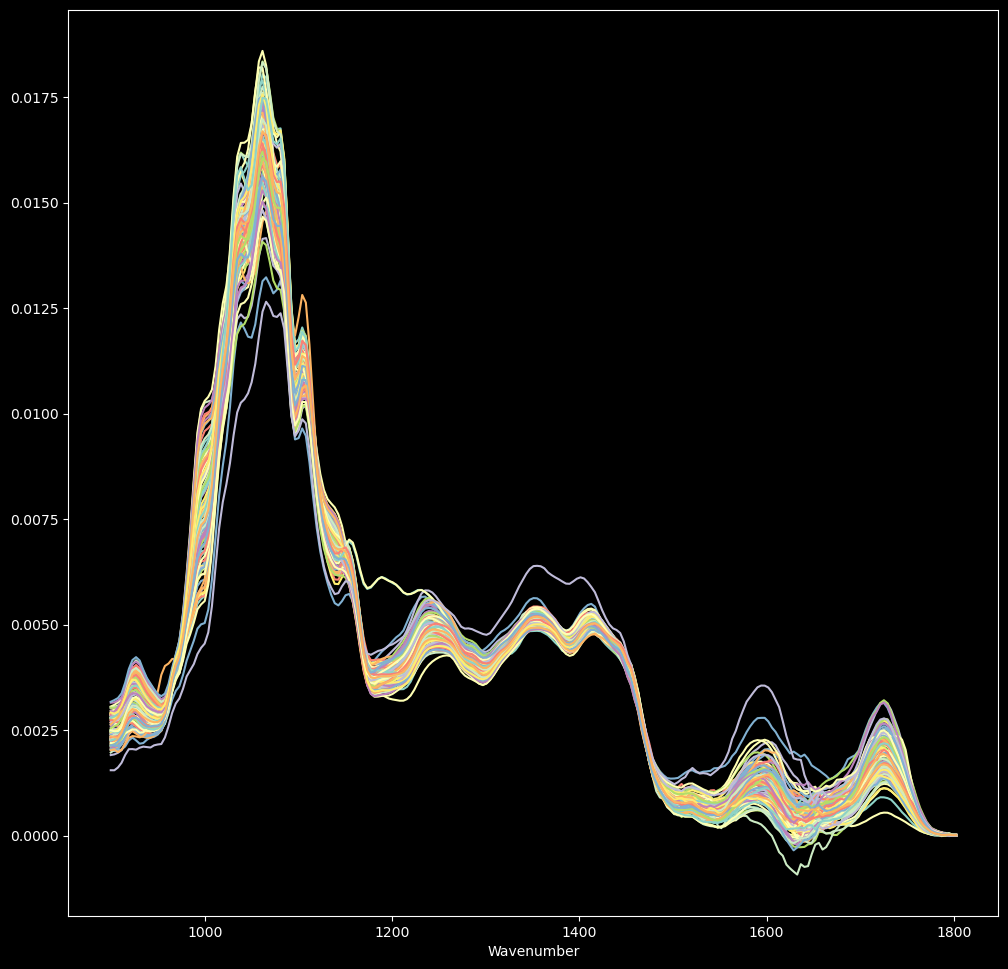

In [22]:
# plot wavenumber vs emission where Strawberry == True
plt.figure(figsize=(12,12))
plt.plot(dfv.query('Outcome == True').loc[:,dfv.columns != 'Outcome'].T)
plt.xlabel('Wavenumber');

<br>

#### Plot the Validation Set where Strawberry == False

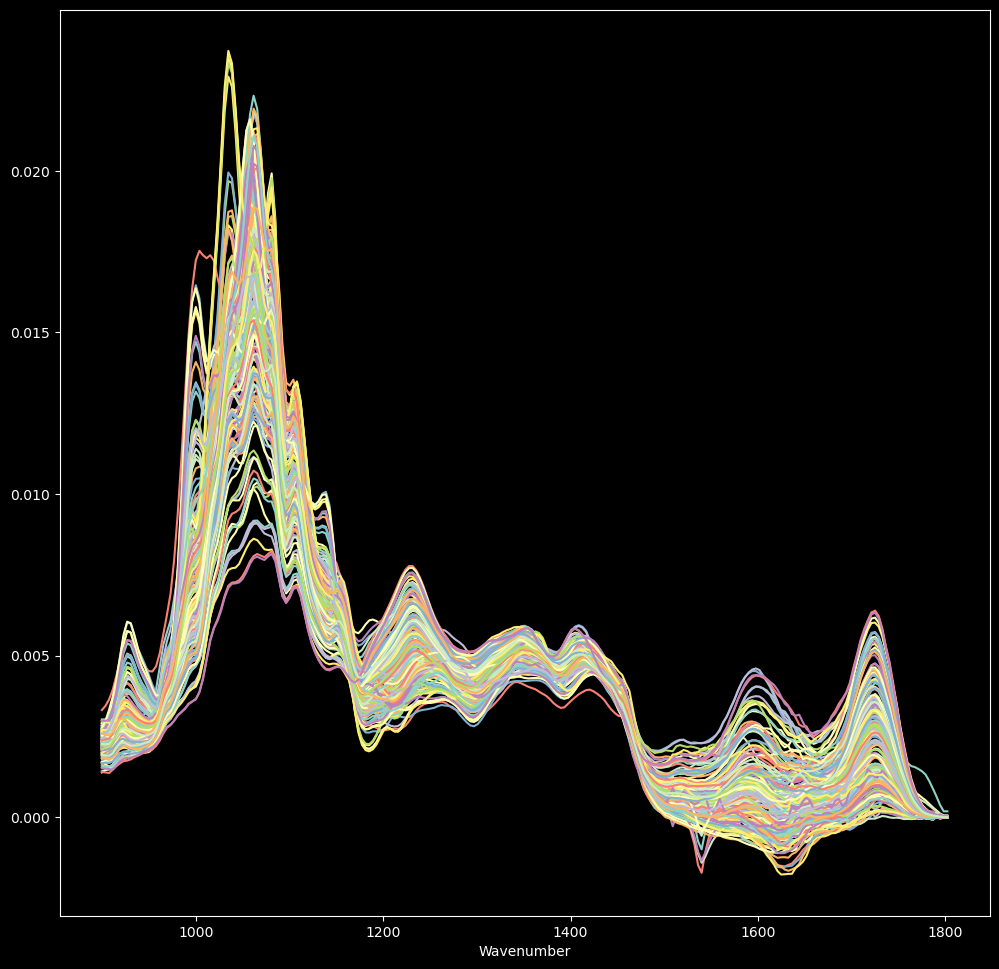

In [23]:
# plot the wavenumber vs emission where Strawberry == False
plt.figure(figsize=(12,12))
plt.plot(dfv.query('Outcome == False').loc[:,dfv.columns != 'Outcome'].T)
plt.xlabel('Wavenumber');

<br>
<br>
<br>
<br>

# Analysis with FastAI

### Define the Learner

In [24]:
from fastai.tabular.all import *

# dls = TabularDataLoaders.from_df(dft, y_names=['Outcome'], procs = [Categorify, FillMissing, Normalize])
dls = TabularDataLoaders.from_df(dft, y_names=['Outcome'])

learn = tabular_learner(dls, lr=1e-3, metrics=[error_rate, accuracy, F1Score(), Precision(), Recall()], layers=[1000,10000,10000,1000]) #, layers=[1000,10000,10000,10000,1000])


<br>
<br>

### ~~Define an Early Callback~~

In [25]:
# early_stop = EarlyStoppingCallback(monitor='error_rate', min_delta=0.1, patience=2)

<br>
<br>

## Fit the model

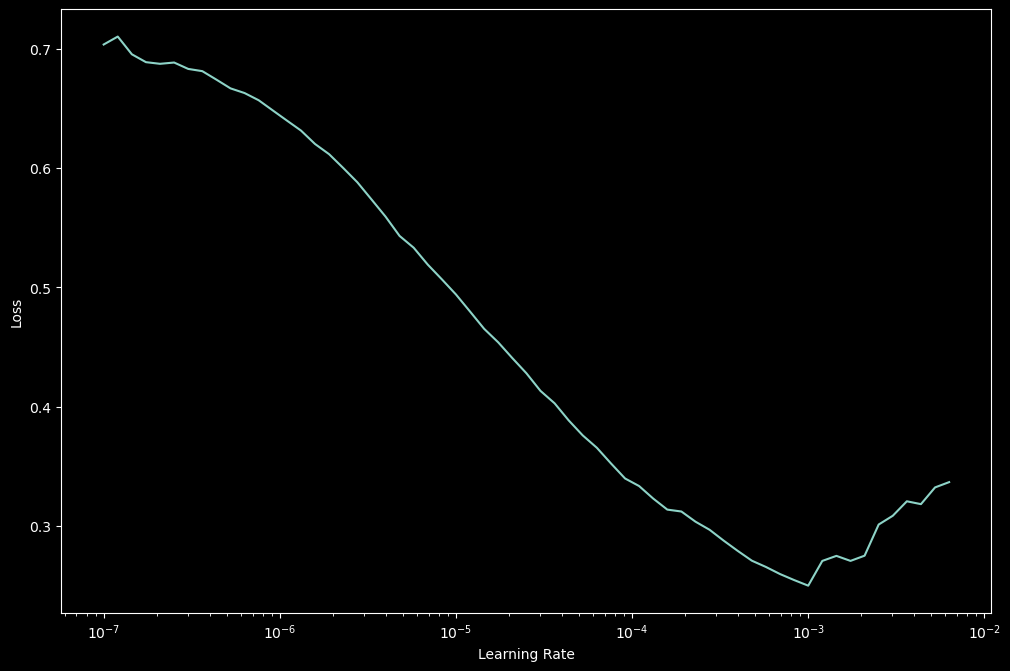

In [26]:
# plot the learning rates vs loss
lr_min,lr_steep = learn.lr_find()

In [27]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.00e-04, steepest point: 3.98e-06


In [28]:
learn.fit_one_cycle(35)

epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,0.334759,0.676413,0.408759,0.591241,0.000000,0.000000,0.000000,00:00
1,0.220099,0.986129,0.591241,0.408759,0.580311,0.408759,1.000000,00:00
2,0.174916,0.972534,0.408759,0.591241,0.000000,0.000000,0.000000,00:00
3,0.149084,1.251242,0.591241,0.408759,0.580311,0.408759,1.000000,00:00
4,0.144397,0.921557,0.591241,0.408759,0.580311,0.408759,1.000000,00:00
5,0.165952,0.643667,0.284672,0.715328,0.734694,0.593407,0.964286,00:00
6,0.170012,1.354543,0.591241,0.408759,0.580311,0.408759,1.000000,00:00
7,0.164444,2.336399,0.569343,0.430657,0.589474,0.417910,1.000000,00:00
8,0.160365,0.297867,0.102190,0.897810,0.888889,0.800000,1.000000,00:00
9,0.147178,0.569607,0.328467,0.671533,0.713376,0.554455,1.000000,00:00


/home/frank/miniconda3/envs/learn/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/frank/miniconda3/envs/learn/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
# learn.fine_tune(4)

<br>
<br>

### Visualize the Training Set Results


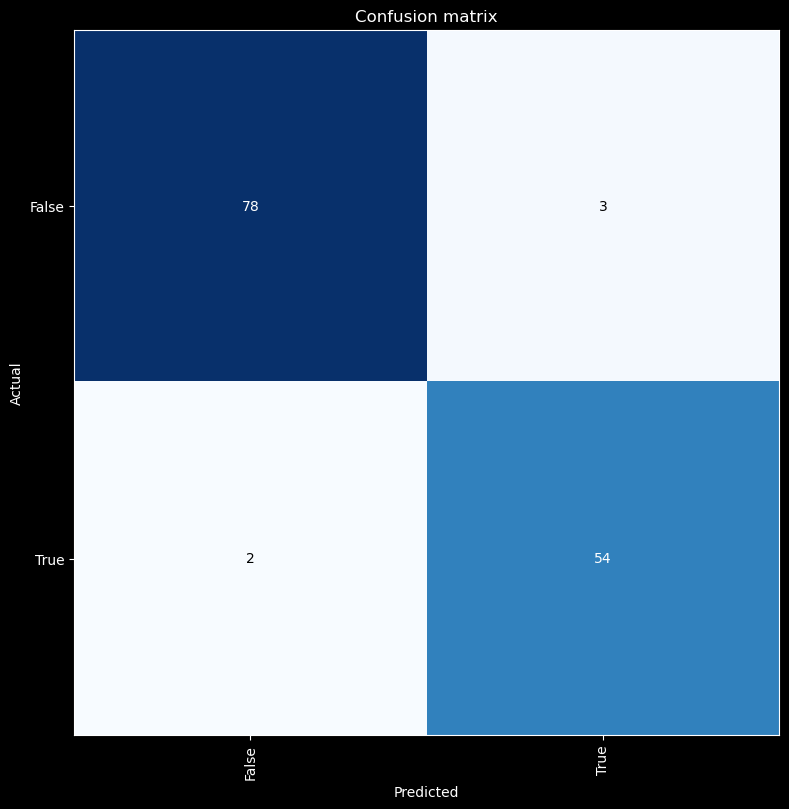

In [30]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8))

<br>
<br>
<br>

# Show Predictions

<br>

### Make a Random Prediction on an Item in the Validation Set

In [31]:
rown = 3
row = dfv.iloc[rown, :-1]

print(f'Actually a Strawberry:           {dfv.iloc[rown, -1]}')
print(f'Predicted to be a Strawberry:    { bool(learn.predict(row=row)[1]) }')
# print(f'Predicted to be a Strawberry:    { bool(learn.predict(row=row)[-1][1].item()) }')

Actually a Strawberry:           True


Predicted to be a Strawberry:    True


<br>
<br>
<br>

## Iteratively Predict Over the Entire Validation Set (Manually)

In [32]:
TP = 0
TN = 0
FP = 0
FN = 0

print('idx'.rjust(4) + '    ' + 'Actual'.ljust(6) + '   Predicted' )

for i in range(len(dfv)):
    actual = dfv.iloc[i, -1]
    predicted = bool(learn.predict(row=dfv.iloc[i, :-1])[1].item())
    
    print(f'{str(i).rjust(4)}    {str(actual).ljust(6)}   {predicted}')
    
    if (predicted == True):
        if (actual == True): TP += 1
        else: FP += 1
            
    if (predicted == False):
        if (actual == False): TN += 1
        else: FN += 1
        
print("\n")
print(f'True Positive={TP}')
print(f'True Negative={TN}')
print(f'False Positive={FP}')
print(f'False Negative={FN}');

 idx    Actual   Predicted


   0    True     True


   1    False    False


   2    True     True


   3    True     True


   4    False    False


   5    False    False


   6    False    False


   7    False    False


   8    False    False


   9    False    False


  10    True     True


  11    False    False


  12    True     False


  13    True     True


  14    True     True


  15    True     True


  16    False    False


  17    False    False


  18    False    False


  19    False    False


  20    False    False


  21    True     True


  22    False    False


  23    False    False


  24    False    False


  25    False    False


  26    False    False


  27    False    False


  28    False    False


  29    True     True


  30    False    False


  31    True     False


  32    False    False


  33    True     True


  34    False    False


  35    False    False


  36    False    False


  37    False    False


  38    False    False


  39    True     True


  40    True     True


  41    False    False


  42    True     True


  43    False    False


  44    False    False


  45    False    False


  46    False    False


  47    False    False


  48    False    False


  49    True     True


  50    False    False


  51    False    False


  52    True     True


  53    False    False


  54    False    False


  55    False    False


  56    True     True


  57    True     True


  58    True     True


  59    True     True


  60    True     True


  61    False    False


  62    False    False


  63    False    False


  64    True     True


  65    True     False


  66    False    False


  67    True     True


  68    False    False


  69    True     True


  70    False    False


  71    True     True


  72    False    False


  73    False    False


  74    False    False


  75    True     True


  76    False    False


  77    False    False


  78    True     True


  79    False    False


  80    False    False


  81    False    False


  82    True     False


  83    False    False


  84    False    False


  85    True     True


  86    False    False


  87    False    False


  88    True     True


  89    True     True


  90    False    False


  91    False    False


  92    False    False


  93    True     True


  94    True     True


  95    False    False


  96    False    False


  97    True     True


  98    False    False


  99    False    False


 100    False    False


 101    False    False


 102    False    False


 103    False    False


 104    False    False


 105    True     True


 106    False    False


 107    False    False


 108    False    False


 109    False    False


 110    True     True


 111    False    False


 112    False    False


 113    False    False


 114    False    False


 115    True     True


 116    False    False


 117    True     True


 118    False    False


 119    True     True


 120    False    False


 121    False    False


 122    False    False


 123    False    False


 124    False    False


 125    True     True


 126    False    False


 127    False    False


 128    True     True


 129    False    False


 130    True     True


 131    False    False


 132    False    False


 133    False    False


 134    True     True


 135    False    False


 136    False    False


 137    False    False


 138    False    False


 139    True     True


 140    False    False


 141    False    False


 142    False    False


 143    False    False


 144    True     True


 145    False    False


 146    False    False


 147    True     True


 148    False    False


 149    True     True


 150    False    False


 151    True     True


 152    False    False


 153    False    False


 154    False    False


 155    False    False


 156    False    False


 157    True     True


 158    False    False


 159    True     True


 160    True     True


 161    True     True


 162    True     True


 163    True     True


 164    True     True


 165    True     True


 166    False    False


 167    False    False


 168    False    False


 169    False    False


 170    False    False


 171    False    False


 172    False    False


 173    False    False


 174    False    False


 175    True     False


 176    False    False


 177    False    False


 178    False    False


 179    False    False


 180    True     True


 181    True     True


 182    False    False


 183    False    False


 184    True     True


 185    False    False


 186    False    False


 187    False    False


 188    True     True


 189    True     True


 190    True     True


 191    True     True


 192    True     True


 193    True     True


 194    False    False


 195    False    False


 196    False    False


 197    False    False


 198    False    False


 199    True     True


 200    True     True


 201    True     True


 202    False    False


 203    False    False


 204    True     True


 205    False    False


 206    True     True


 207    False    False


 208    True     True


 209    True     True


 210    False    False


 211    False    False


 212    True     True


 213    True     True


 214    False    False


 215    True     True


 216    False    False


 217    True     True


 218    False    False


 219    False    False


 220    False    False


 221    True     True


 222    True     True


 223    True     False


 224    True     True


 225    False    False


 226    False    False


 227    False    False


 228    True     True


 229    False    False


 230    False    False


 231    False    False


 232    False    False


 233    False    False


 234    False    False


 235    False    False


 236    True     True


 237    True     True


 238    False    False


 239    True     True


 240    False    False


 241    False    False


 242    True     True


 243    True     True


 244    False    False


 245    True     True


 246    True     True


 247    False    False


 248    False    False


 249    False    False


 250    True     True


 251    True     True


 252    False    False


 253    False    False


 254    False    False


 255    False    False


 256    False    False


 257    True     True


 258    True     True


 259    False    False


 260    False    False


 261    True     True


 262    False    False


 263    True     True


 264    False    False


 265    False    False


 266    False    False


 267    False    False


 268    True     True


 269    False    False


 270    False    False


 271    False    False


 272    True     True


 273    False    False


 274    False    False


 275    False    False


 276    False    False


 277    False    False


 278    False    False


 279    False    False


 280    False    False


 281    True     True


 282    True     True


 283    True     True


 284    False    False


 285    True     True


 286    False    False


 287    False    False


 288    False    False


 289    False    False


 290    True     True


 291    False    False


 292    True     True


 293    False    False


 294    True     True


True Positive=100
True Negative=189
False Positive=0
False Negative=6


<br>
<br>
<br>

# Score the Predictions (FastAI Version)

In [33]:
accuracy = (TP + TN) / len(dfv)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
F1 = (2 * precision * recall) / (precision + recall)

print('\nFastAI Predictions: \n')
print(f'Accuracy:    {round(accuracy,4)}')
print(f'Precision:   {round(precision,4)}')
print(f'Recall:      {round(recall,4)}')
print(f'F1 Score:    {round(F1,4)}')


FastAI Predictions: 

Accuracy:    0.9797
Precision:   1.0
Recall:      0.9434
F1 Score:    0.9709


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Let's Play with Tensorflow/Keras!

Here we implement a simple backprop network using Keras.

In [34]:
from sklearn.model_selection import train_test_split
import tensorflow.keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import class_weight



In [35]:
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size = 0.25)
dft_orig = dft.copy().astype('float32')
dfv_orig = dfv.copy().astype('float32')
# dft = dft_orig.copy().astype('float32')
# dfv = dfv_orig.copy().astype('float32')
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
dft = scaler_x.fit_transform(dft)
dfv = scaler_y.fit_transform(dfv)
dft = pd.DataFrame(dft, columns=dft_orig.columns)
dfv = pd.DataFrame(dfv, columns=dfv_orig.columns)


In [45]:
# dft

In [46]:
# dfv

In [47]:

model = Sequential()
model.add(Dense(1000, input_dim=235, activation='relu'))
model.add(Dense(10000, activation='relu'))
# model.add(Dense(10000, activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1000)              236000    
_________________________________________________________________
dense_5 (Dense)              (None, 10000)             10010000  
_________________________________________________________________
dense_6 (Dense)              (None, 1000)              10001000  
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 1001      
Total params: 20,248,001
Trainable params: 20,248,001
Non-trainable params: 0
_________________________________________________________________


In [48]:
# model.compile(optimizer='adam', loss='mean_squared_error')
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# weights = class_weight.compute_class_weight(class_weight='balanced',
#                                             classes=np.unique(dft.iloc[:,-1]),
#                                             y=dft.iloc[:,-1])
# weights

In [49]:
epochs_hist = model.fit(dft.iloc[:,:-1].values, dft.iloc[:,-1], epochs=100, batch_size=24,  verbose=1, validation_split=0.25)


Epoch 1/100
22/22 [==============================] - 1s 12ms/step - loss: 4.2122 - accuracy: 0.6625 - val_loss: 0.4906 - val_accuracy: 0.7733
Epoch 2/100
22/22 [==============================] - 0s 9ms/step - loss: 0.5233 - accuracy: 0.7655 - val_loss: 0.7233 - val_accuracy: 0.6395
Epoch 3/100
22/22 [==============================] - 0s 9ms/step - loss: 0.5287 - accuracy: 0.7395 - val_loss: 0.5101 - val_accuracy: 0.7907
Epoch 4/100
22/22 [==============================] - 0s 9ms/step - loss: 0.8916 - accuracy: 0.7209 - val_loss: 0.3883 - val_accuracy: 0.8256
Epoch 5/100
22/22 [==============================] - 0s 9ms/step - loss: 0.3540 - accuracy: 0.8496 - val_loss: 0.7637 - val_accuracy: 0.6686
Epoch 6/100
22/22 [==============================] - 0s 9ms/step - loss: 0.4247 - accuracy: 0.7792 - val_loss: 0.4966 - val_accuracy: 0.6628
Epoch 7/100
22/22 [==============================] - 0s 9ms/step - loss: 0.5424 - accuracy: 0.7270 - val_loss: 0.3143 - val_accuracy: 0.8256
Epoch 8/100


In [50]:
print(epochs_hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


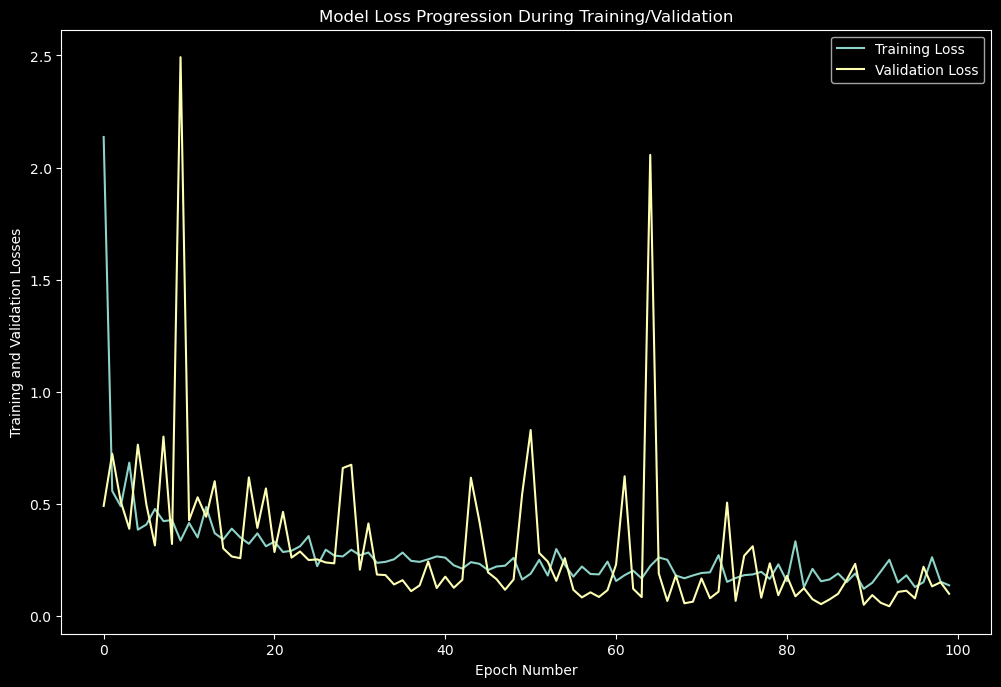

In [51]:
plt.plot(epochs_hist.history['loss'])
plt.plot(epochs_hist.history['val_loss'])

plt.title('Model Loss Progression During Training/Validation')
plt.ylabel('Training and Validation Losses')
plt.xlabel('Epoch Number')
plt.legend(['Training Loss', 'Validation Loss'])

In [52]:
TP = 0
TN = 0
FP = 0
FN = 0

print('idx'.rjust(4) + '    ' + 'Actual'.ljust(6) + '   Predicted' )

for i in range(len(dfv)):
    actual = bool(dfv.iloc[i, -1])
    predicted = bool(np.round(model.predict(dfv.iloc[i, :-1].values.reshape((1,235))), decimals=0))
    
    print(f'{str(i).rjust(4)}    {str(actual).ljust(6)}   {predicted}')
    
    if (predicted == True):
        if (actual == True): TP += 1
        else: FP += 1
            
    if (predicted == False):
        if (actual == False): TN += 1
        else: FN += 1
        
print("\n")
print(f'True Positive={TP}')
print(f'True Negative={TN}')
print(f'False Positive={FP}')
print(f'False Negative={FN}');

 idx    Actual   Predicted
   0    True     True
   1    False    False
   2    True     False
   3    True     True
   4    False    False
   5    False    False
   6    False    False
   7    False    False
   8    False    False
   9    False    False
  10    True     True
  11    False    False
  12    True     False
  13    True     True
  14    True     False
  15    True     True
  16    False    False
  17    False    True
  18    False    False
  19    False    False
  20    False    False
  21    True     True
  22    False    False
  23    False    False
  24    False    False
  25    False    False
  26    False    False
  27    False    False
  28    False    False
  29    True     True
  30    False    False
  31    True     True
  32    False    False
  33    True     True
  34    False    False
  35    False    False
  36    False    False
  37    False    False
  38    False    False
  39    True     True
  40    True     True
  41    False    False
  42    True     Tr

<br>
<br>
<br>

# Score the Predictions (TensorFlow Version)

In [53]:
accuracy = (TP + TN) / len(dfv)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
F1 = (2 * precision * recall) / (precision + recall)

print('\nTensorflow Predictions: \n')
print(f'Accuracy:    {round(accuracy,4)}')
print(f'Precision:   {round(precision,4)}')
print(f'Recall:      {round(recall,4)}')
print(f'F1 Score:    {round(F1,4)}')


Tensorflow Predictions: 

Accuracy:    0.9492
Precision:   0.9333
Recall:      0.9245
F1 Score:    0.9289


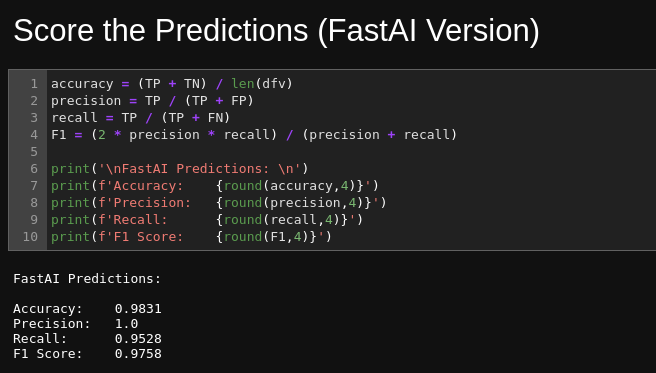

This is a screenshot from the previous analysis with FastAI (earlier in this notebook)